In [1]:
import numpy as np
import pygmt as pygmt
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from faultSlip.inversion import Inversion
from faultSlip.utils import *

# Right laterl strike slip
## strike 0
## dip 90
## strike element = -1

In [67]:
strike, dip = 0, 60

In [68]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * 0.1

/var/folders/c_/7wmr5s157236k916wk7m39800000gn/T/ipykernel_34347/710888491.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))


In [69]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [70]:
x = 50.01
y = 50.01
z = 0.2
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = 10.0
W = 10.0
slip_strike = 0.0
slip_dip = 1.0
s_open = 0.0

In [71]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[50.01      , 45.01      ,  0.2       ],
       [50.01      , 55.01      ,  0.2       ],
       [55.01      , 55.01      ,  8.86025404],
       [55.01      , 45.01      ,  8.86025404]])

In [72]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false,
	"origin_lon":0,
	"origin_lat":0
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [73]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

# reciver dislocation
## calculating the stress on the same orentaion (dip:90 strike:0)
## rake:180 represent right lateral strike slip

In [74]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(np.array([1]))
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


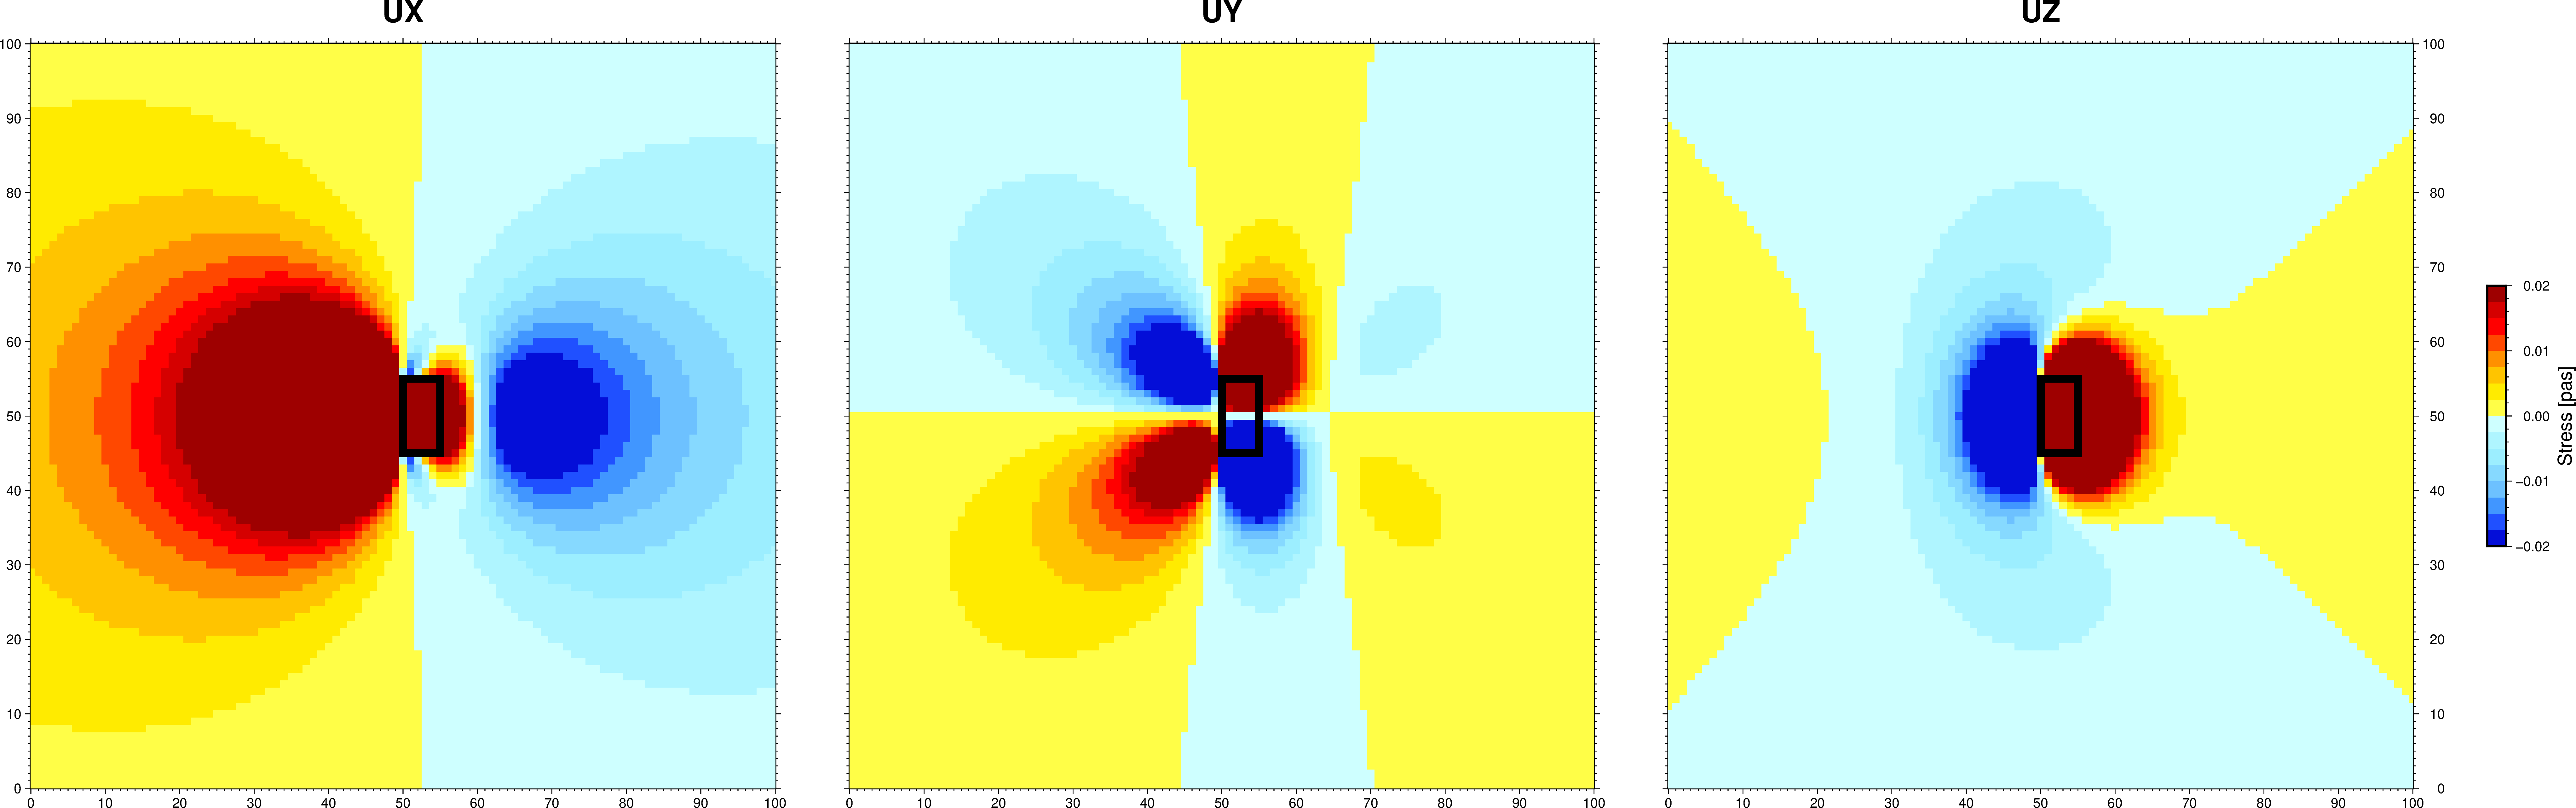

In [75]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [76]:

# Assuming ux, uy, and uz are numpy arrays of the same shape
disp = np.stack((inv_ux, inv_uy, inv_uz), axis=-1)

In [77]:
disp.shape

(101, 101, 3)

In [78]:
def los_unit_vector(theta, I):
    # Calculate the LOS unit vector components
    x = np.sin(I2) * np.cos(theta)
    y = np.sin(I2) * np.sin(theta)
    z = np.cos(I2)
    los = np.array([x, y, z])
    return -los 
def boi_unit_vector(theta):
    # Calculate the LOS unit vector components
    x =  np.sin(theta)
    y =  np.cos(theta)
    z = 0
    boi = np.array([x, y, z])
    return boi

In [79]:
theta1 = np.radians(-13.1289561)
I1 = np.radians(39.6409)
theta2 = np.radians(193.1344263 )
I2 = np.radians(39.5275)

In [80]:
los1 = los_unit_vector(theta1, I1)
los2 = los_unit_vector(theta2, I2)
boi1 = boi_unit_vector(theta1)

In [81]:
LOS1 = get_array(disp.dot(los1), X[0, :], Y[:, 0])
LOS2 = get_array(disp.dot(los2), X[0, :], Y[:, 0])
BOI1 = get_array(disp.dot(boi1), X[0, :], Y[:, 0])

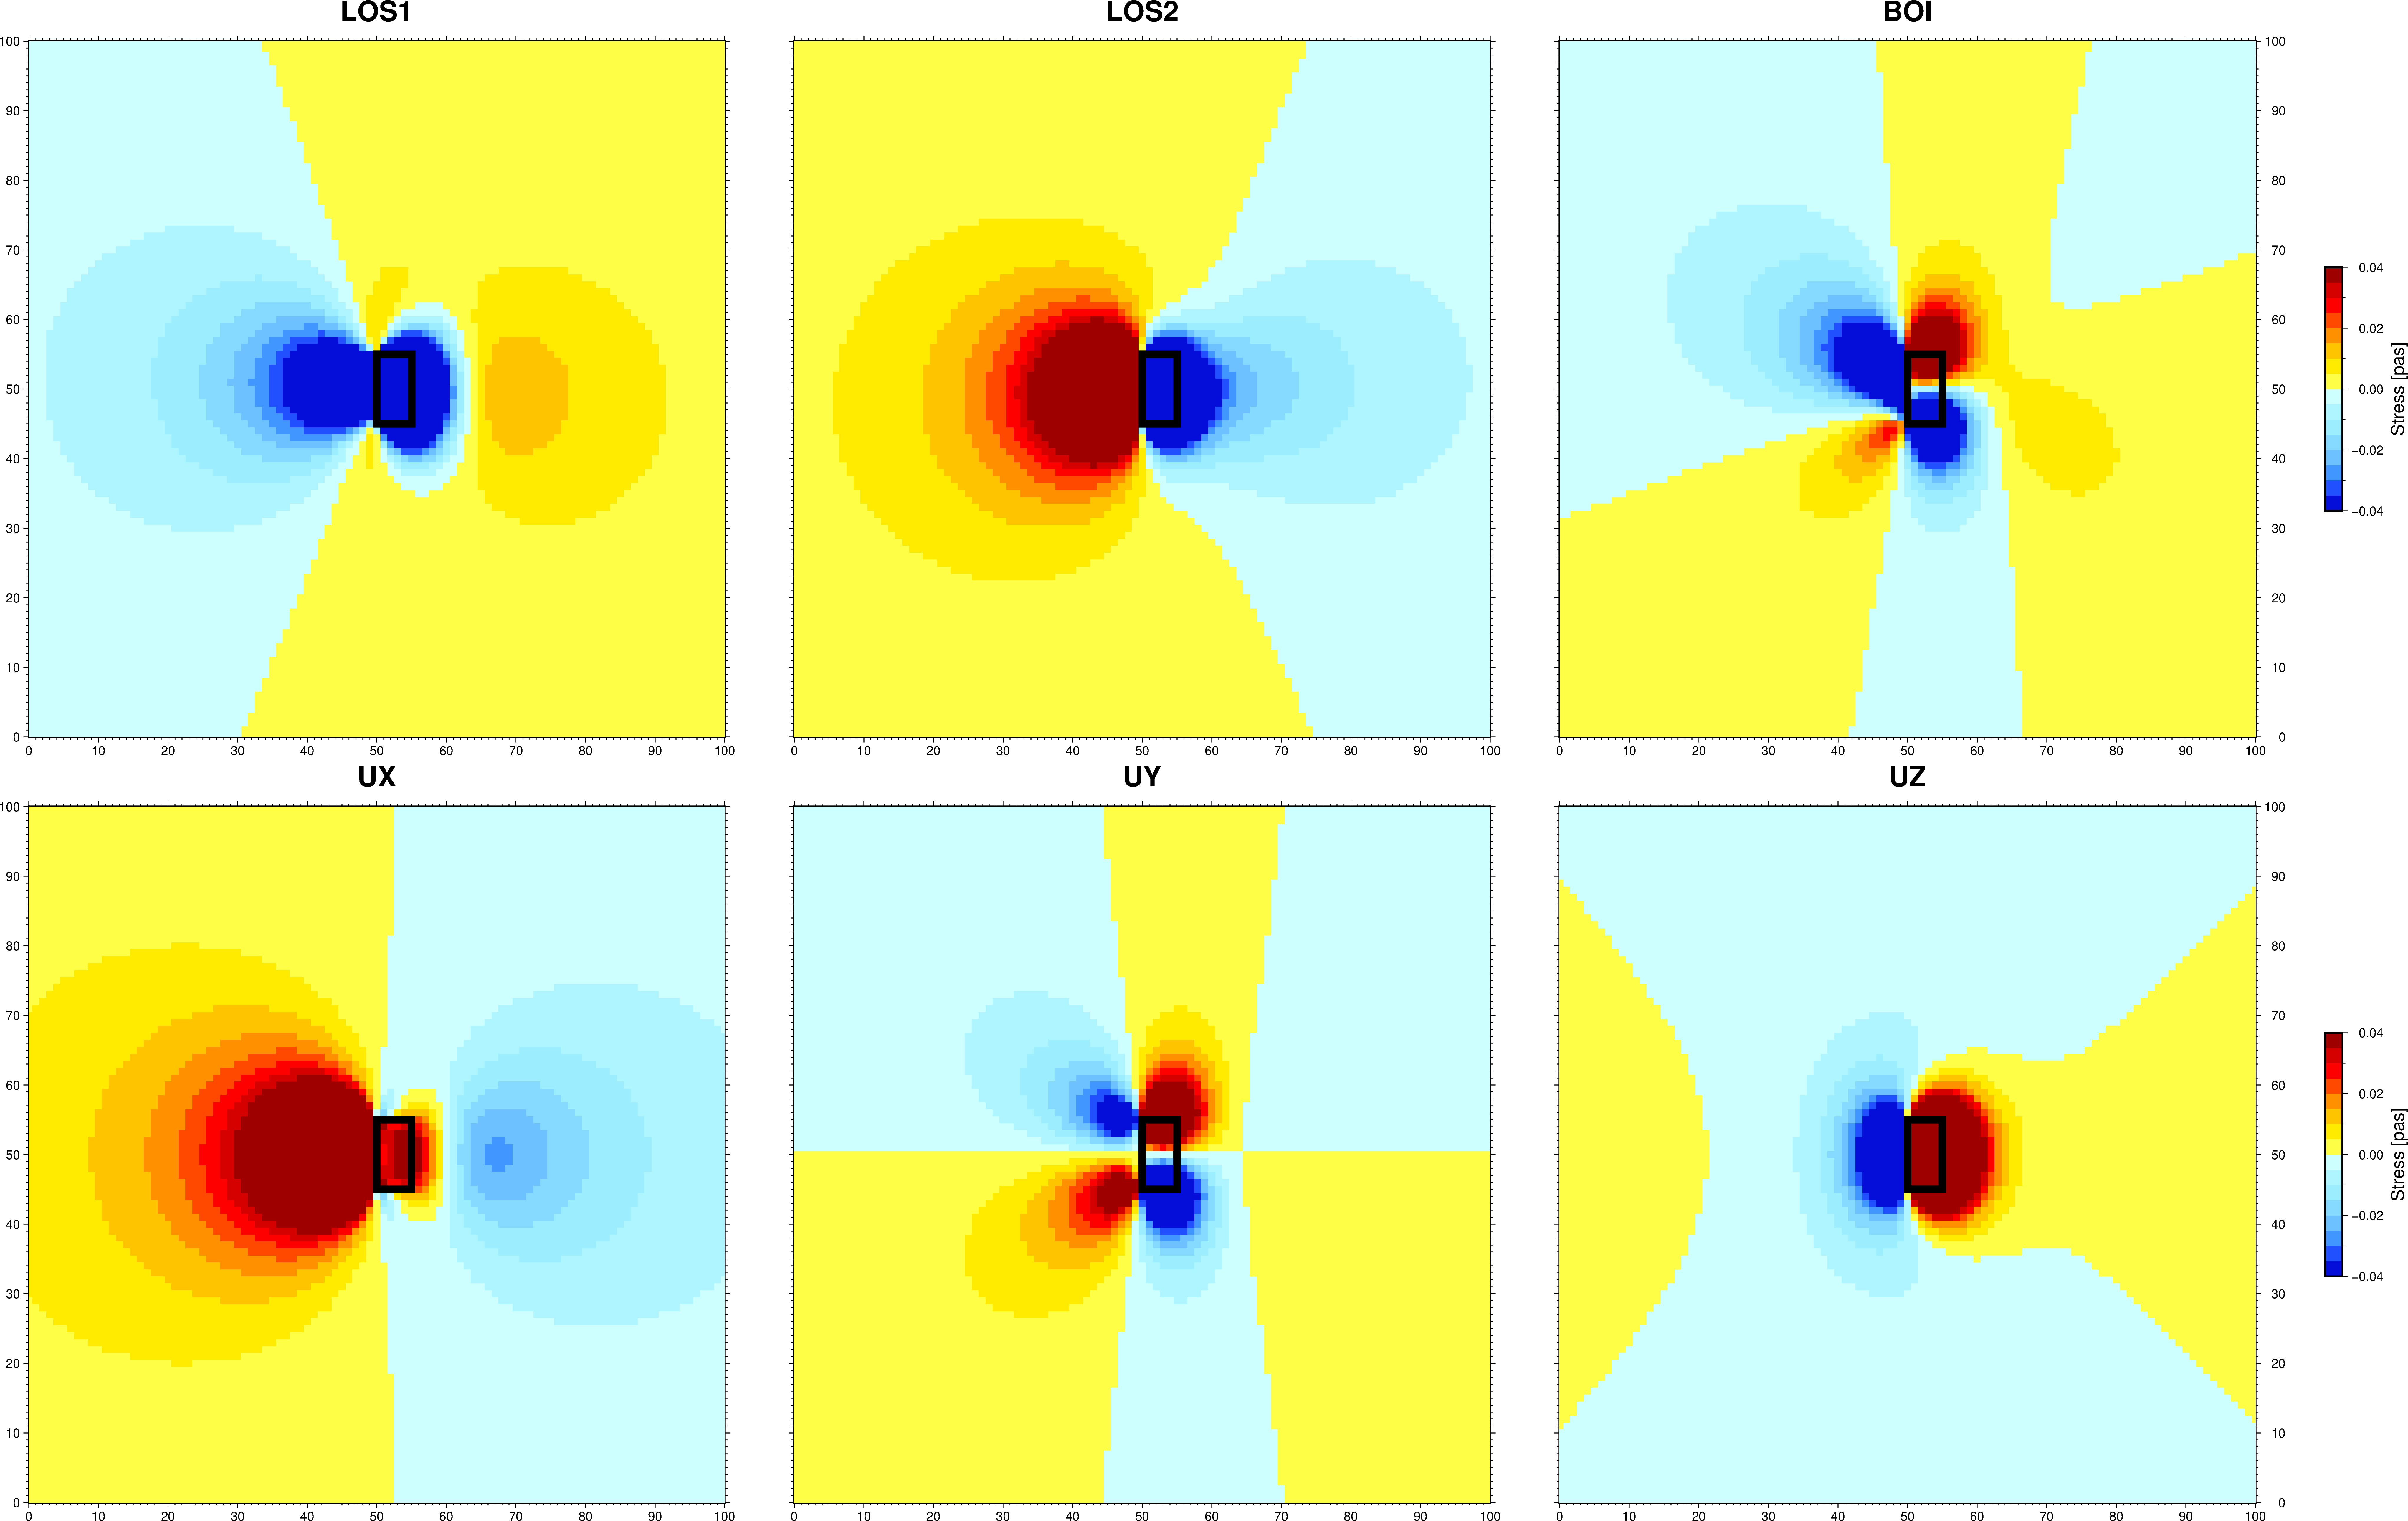

In [82]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.04#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.04#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44', yshift='22')

fig.basemap(
    frame=['WSne+t"LOS1"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=LOS1)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"LOS2"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=LOS2)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"BOI"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=BOI1)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [83]:
los_unit_vector(theta1, I1)

array([-0.61981256,  0.14456514, -0.7713192 ])

In [84]:
boi_unit_vector(theta1)

array([-0.22714351,  0.9738613 ,  0.        ])